In [12]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Dataset & Dataloader

In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [14]:
bs = 128

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('data/data/train/', transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder('data/data/test/', transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True, num_workers=2)

In [ ]:
feature, target = next(iter(trainloader))
feature.shape


torch.Size([128, 1, 28, 28])

In [16]:
label2cat = train_set.classes
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# Arsitektur & Config

In [17]:
from jcopdl.layers import linear_block

In [18]:
class FashionClassifier(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout=dropout),
            linear_block(n1, n2, dropout=dropout),
            linear_block(n2, output_size, activation='lsoftmax')
        )
    
    def forward(self, x):
        return self.fc(x)

In [19]:
config = set_config({
    'input_size': 784,
    'n1': 256,
    'n2': 64,
    'output_size': len(train_set.classes),
    'dropout': 0.2
})

# Training Preparation -> MCOC

In [20]:
model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback =  Callback(model, config, outdir='model')

# Training

In [21]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode =="train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()

    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/313 [00:08<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch     7
Train_cost  = 0.3262 | Test_cost  = 0.3249 | Train_score = 0.8819 | Test_score = 0.8813 |


Train:   0%|          | 0/313 [00:08<?, ?it/s]

Test:   0%|          | 0/157 [00:38<?, ?it/s]


Epoch     8
Train_cost  = 0.3126 | Test_cost  = 0.3299 | Train_score = 0.8853 | Test_score = 0.8803 |
==> EarlyStop patience =  1 | Best test_score: 0.8813


Train:   0%|          | 0/313 [00:08<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch     9
Train_cost  = 0.3063 | Test_cost  = 0.3096 | Train_score = 0.8887 | Test_score = 0.8864 |


Train:   0%|          | 0/313 [00:08<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    10
Train_cost  = 0.2959 | Test_cost  = 0.3176 | Train_score = 0.8911 | Test_score = 0.8852 |
==> EarlyStop patience =  1 | Best test_score: 0.8864


Train:   0%|          | 0/313 [00:18<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    11
Train_cost  = 0.2902 | Test_cost  = 0.3388 | Train_score = 0.8945 | Test_score = 0.8742 |
==> EarlyStop patience =  2 | Best test_score: 0.8864


Train:   0%|          | 0/313 [00:08<?, ?it/s]

Test:   0%|          | 0/157 [00:18<?, ?it/s]


Epoch    12
Train_cost  = 0.2825 | Test_cost  = 0.3081 | Train_score = 0.8952 | Test_score = 0.8866 |


Train:   0%|          | 0/313 [00:09<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    13
Train_cost  = 0.2763 | Test_cost  = 0.3186 | Train_score = 0.8975 | Test_score = 0.8849 |
==> EarlyStop patience =  1 | Best test_score: 0.8866


Train:   0%|          | 0/313 [00:08<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    14
Train_cost  = 0.2705 | Test_cost  = 0.3120 | Train_score = 0.9002 | Test_score = 0.8875 |


Train:   0%|          | 0/313 [00:09<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    15
Train_cost  = 0.2640 | Test_cost  = 0.3235 | Train_score = 0.9023 | Test_score = 0.8835 |
==> EarlyStop patience =  1 | Best test_score: 0.8875


Train:   0%|          | 0/313 [00:08<?, ?it/s]

Test:   0%|          | 0/157 [00:19<?, ?it/s]


Epoch    16
Train_cost  = 0.2610 | Test_cost  = 0.3201 | Train_score = 0.9036 | Test_score = 0.8865 |
==> EarlyStop patience =  2 | Best test_score: 0.8875


Train:   0%|          | 0/313 [00:08<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    17
Train_cost  = 0.2558 | Test_cost  = 0.3084 | Train_score = 0.9043 | Test_score = 0.8890 |


Train:   0%|          | 0/313 [00:09<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    18
Train_cost  = 0.2516 | Test_cost  = 0.3181 | Train_score = 0.9069 | Test_score = 0.8848 |
==> EarlyStop patience =  1 | Best test_score: 0.8890


Train:   0%|          | 0/313 [00:08<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    19
Train_cost  = 0.2460 | Test_cost  = 0.3213 | Train_score = 0.9074 | Test_score = 0.8867 |
==> EarlyStop patience =  2 | Best test_score: 0.8890


Train:   0%|          | 0/313 [00:18<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    20
Train_cost  = 0.2411 | Test_cost  = 0.3221 | Train_score = 0.9099 | Test_score = 0.8851 |


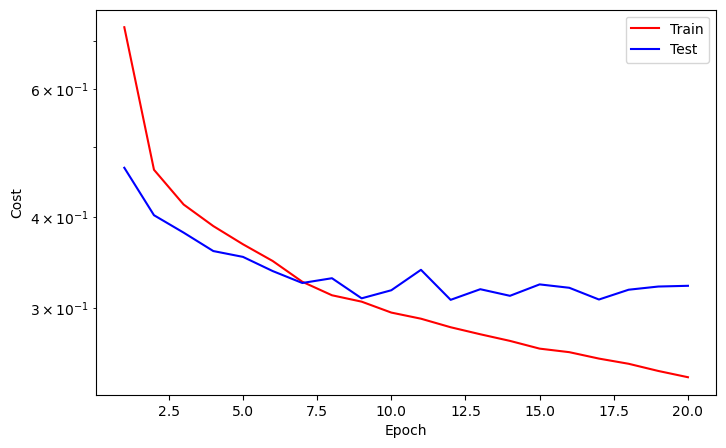

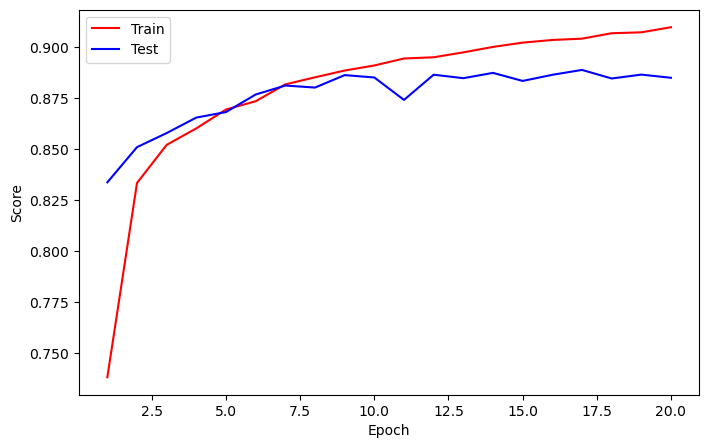

==> EarlyStop patience =  3 | Best test_score: 0.8890


Train:   0%|          | 0/313 [00:09<?, ?it/s]

Test:   0%|          | 0/157 [00:09<?, ?it/s]


Epoch    21
Train_cost  = 0.2365 | Test_cost  = 0.3120 | Train_score = 0.9135 | Test_score = 0.8903 |


Train:   0%|          | 0/313 [00:08<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    22
Train_cost  = 0.2294 | Test_cost  = 0.3164 | Train_score = 0.9147 | Test_score = 0.8910 |


Train:   0%|          | 0/313 [00:08<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    23
Train_cost  = 0.2329 | Test_cost  = 0.3474 | Train_score = 0.9140 | Test_score = 0.8754 |
==> EarlyStop patience =  1 | Best test_score: 0.8910


Train:   0%|          | 0/313 [00:08<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]

Train:   0%|          | 0/313 [00:08<?, ?it/s]


Epoch    24
Train_cost  = 0.2250 | Test_cost  = 0.3140 | Train_score = 0.9163 | Test_score = 0.8923 |


Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    25
Train_cost  = 0.2216 | Test_cost  = 0.3177 | Train_score = 0.9179 | Test_score = 0.8894 |
==> EarlyStop patience =  1 | Best test_score: 0.8923


Train:   0%|          | 0/313 [00:08<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    26
Train_cost  = 0.2221 | Test_cost  = 0.3144 | Train_score = 0.9171 | Test_score = 0.8921 |
==> EarlyStop patience =  2 | Best test_score: 0.8923


Train:   0%|          | 0/313 [00:08<?, ?it/s]

Test:   0%|          | 0/157 [00:09<?, ?it/s]


Epoch    27
Train_cost  = 0.2169 | Test_cost  = 0.3113 | Train_score = 0.9167 | Test_score = 0.8933 |


Train:   0%|          | 0/313 [00:19<?, ?it/s]

Test:   0%|          | 0/157 [00:09<?, ?it/s]


Epoch    28
Train_cost  = 0.2102 | Test_cost  = 0.3252 | Train_score = 0.9220 | Test_score = 0.8916 |
==> EarlyStop patience =  1 | Best test_score: 0.8933


Train:   0%|          | 0/313 [00:09<?, ?it/s]

Test:   0%|          | 0/157 [00:09<?, ?it/s]


Epoch    29
Train_cost  = 0.2078 | Test_cost  = 0.3160 | Train_score = 0.9211 | Test_score = 0.8951 |


Train:   0%|          | 0/313 [00:09<?, ?it/s]

Test:   0%|          | 0/157 [00:20<?, ?it/s]


Epoch    30
Train_cost  = 0.2060 | Test_cost  = 0.3174 | Train_score = 0.9223 | Test_score = 0.8946 |
==> EarlyStop patience =  1 | Best test_score: 0.8951


Train:   0%|          | 0/313 [00:09<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    31
Train_cost  = 0.2061 | Test_cost  = 0.3181 | Train_score = 0.9228 | Test_score = 0.8943 |
==> EarlyStop patience =  2 | Best test_score: 0.8951


Train:   0%|          | 0/313 [00:18<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    32
Train_cost  = 0.1985 | Test_cost  = 0.3124 | Train_score = 0.9238 | Test_score = 0.8934 |
==> EarlyStop patience =  3 | Best test_score: 0.8951


Train:   0%|          | 0/313 [00:08<?, ?it/s]

Test:   0%|          | 0/157 [00:18<?, ?it/s]


Epoch    33
Train_cost  = 0.1993 | Test_cost  = 0.3283 | Train_score = 0.9263 | Test_score = 0.8915 |
==> EarlyStop patience =  4 | Best test_score: 0.8951


Train:   0%|          | 0/313 [00:08<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    34
Train_cost  = 0.1951 | Test_cost  = 0.3275 | Train_score = 0.9260 | Test_score = 0.8914 |
==> EarlyStop patience =  5 | Best test_score: 0.8951
==> Execute Early Stopping at epoch: 34 | Best test_score: 0.8951
==> Best model is saved at model


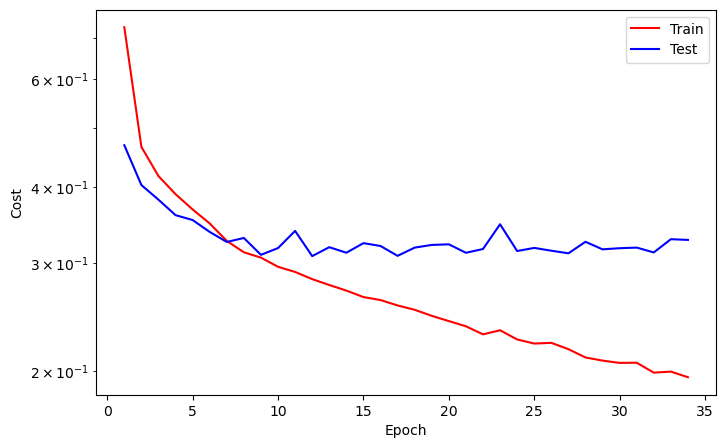

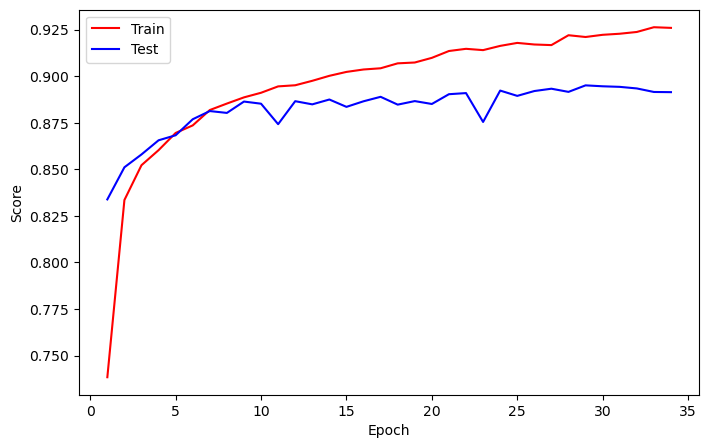

In [23]:
while True:
    train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)

    with torch.no_grad():
        test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor='test_score'):
        callback.plot_cost()
        callback.plot_score()
        break

        

# Load best model

In [ ]:
# weights = torch.load('model/weights_best.pth', map_location='cpu')
# config = torch.load('model/configs.pth', map_location='cpu')

# model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
# model.load_state_dict(weights)
# model = model.to(device)

# Predict

In [24]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [25]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
[label2cat[pred] for pred in preds]

['Coat',
 'Ankle boot',
 'Trouser',
 'Bag',
 'Coat',
 'Sneaker',
 'Ankle boot',
 'Bag',
 'Shirt',
 'Sandal',
 'Pullover',
 'Ankle boot',
 'T-shirt or Top',
 'Trouser',
 'T-shirt or Top',
 'T-shirt or Top',
 'Sandal',
 'Dress',
 'Bag',
 'Bag',
 'Sandal',
 'T-shirt or Top',
 'Coat',
 'Dress',
 'Sneaker',
 'Sandal',
 'Coat',
 'Bag',
 'Ankle boot',
 'Sneaker',
 'T-shirt or Top',
 'Sneaker',
 'Ankle boot',
 'Coat',
 'Coat',
 'Trouser',
 'Pullover',
 'Bag',
 'Sandal',
 'Shirt',
 'Bag',
 'Dress',
 'Sneaker',
 'T-shirt or Top',
 'Coat',
 'T-shirt or Top',
 'Pullover',
 'Trouser',
 'Shirt',
 'T-shirt or Top',
 'Sneaker',
 'Shirt',
 'Bag',
 'Coat',
 'T-shirt or Top',
 'Dress',
 'Dress',
 'Dress',
 'Pullover',
 'Bag',
 'Ankle boot',
 'Sandal',
 'Bag',
 'Bag',
 'Sandal',
 'Bag',
 'T-shirt or Top',
 'Shirt',
 'Ankle boot',
 'Shirt',
 'Pullover',
 'Sandal',
 'Sneaker',
 'Sneaker',
 'Dress',
 'Sandal',
 'Shirt',
 'Shirt',
 'Ankle boot',
 'Trouser',
 'Sandal',
 'T-shirt or Top',
 'Shirt',
 'Dress',
 '

# Visualisasi

In [26]:
import matplotlib.pyplot as plt

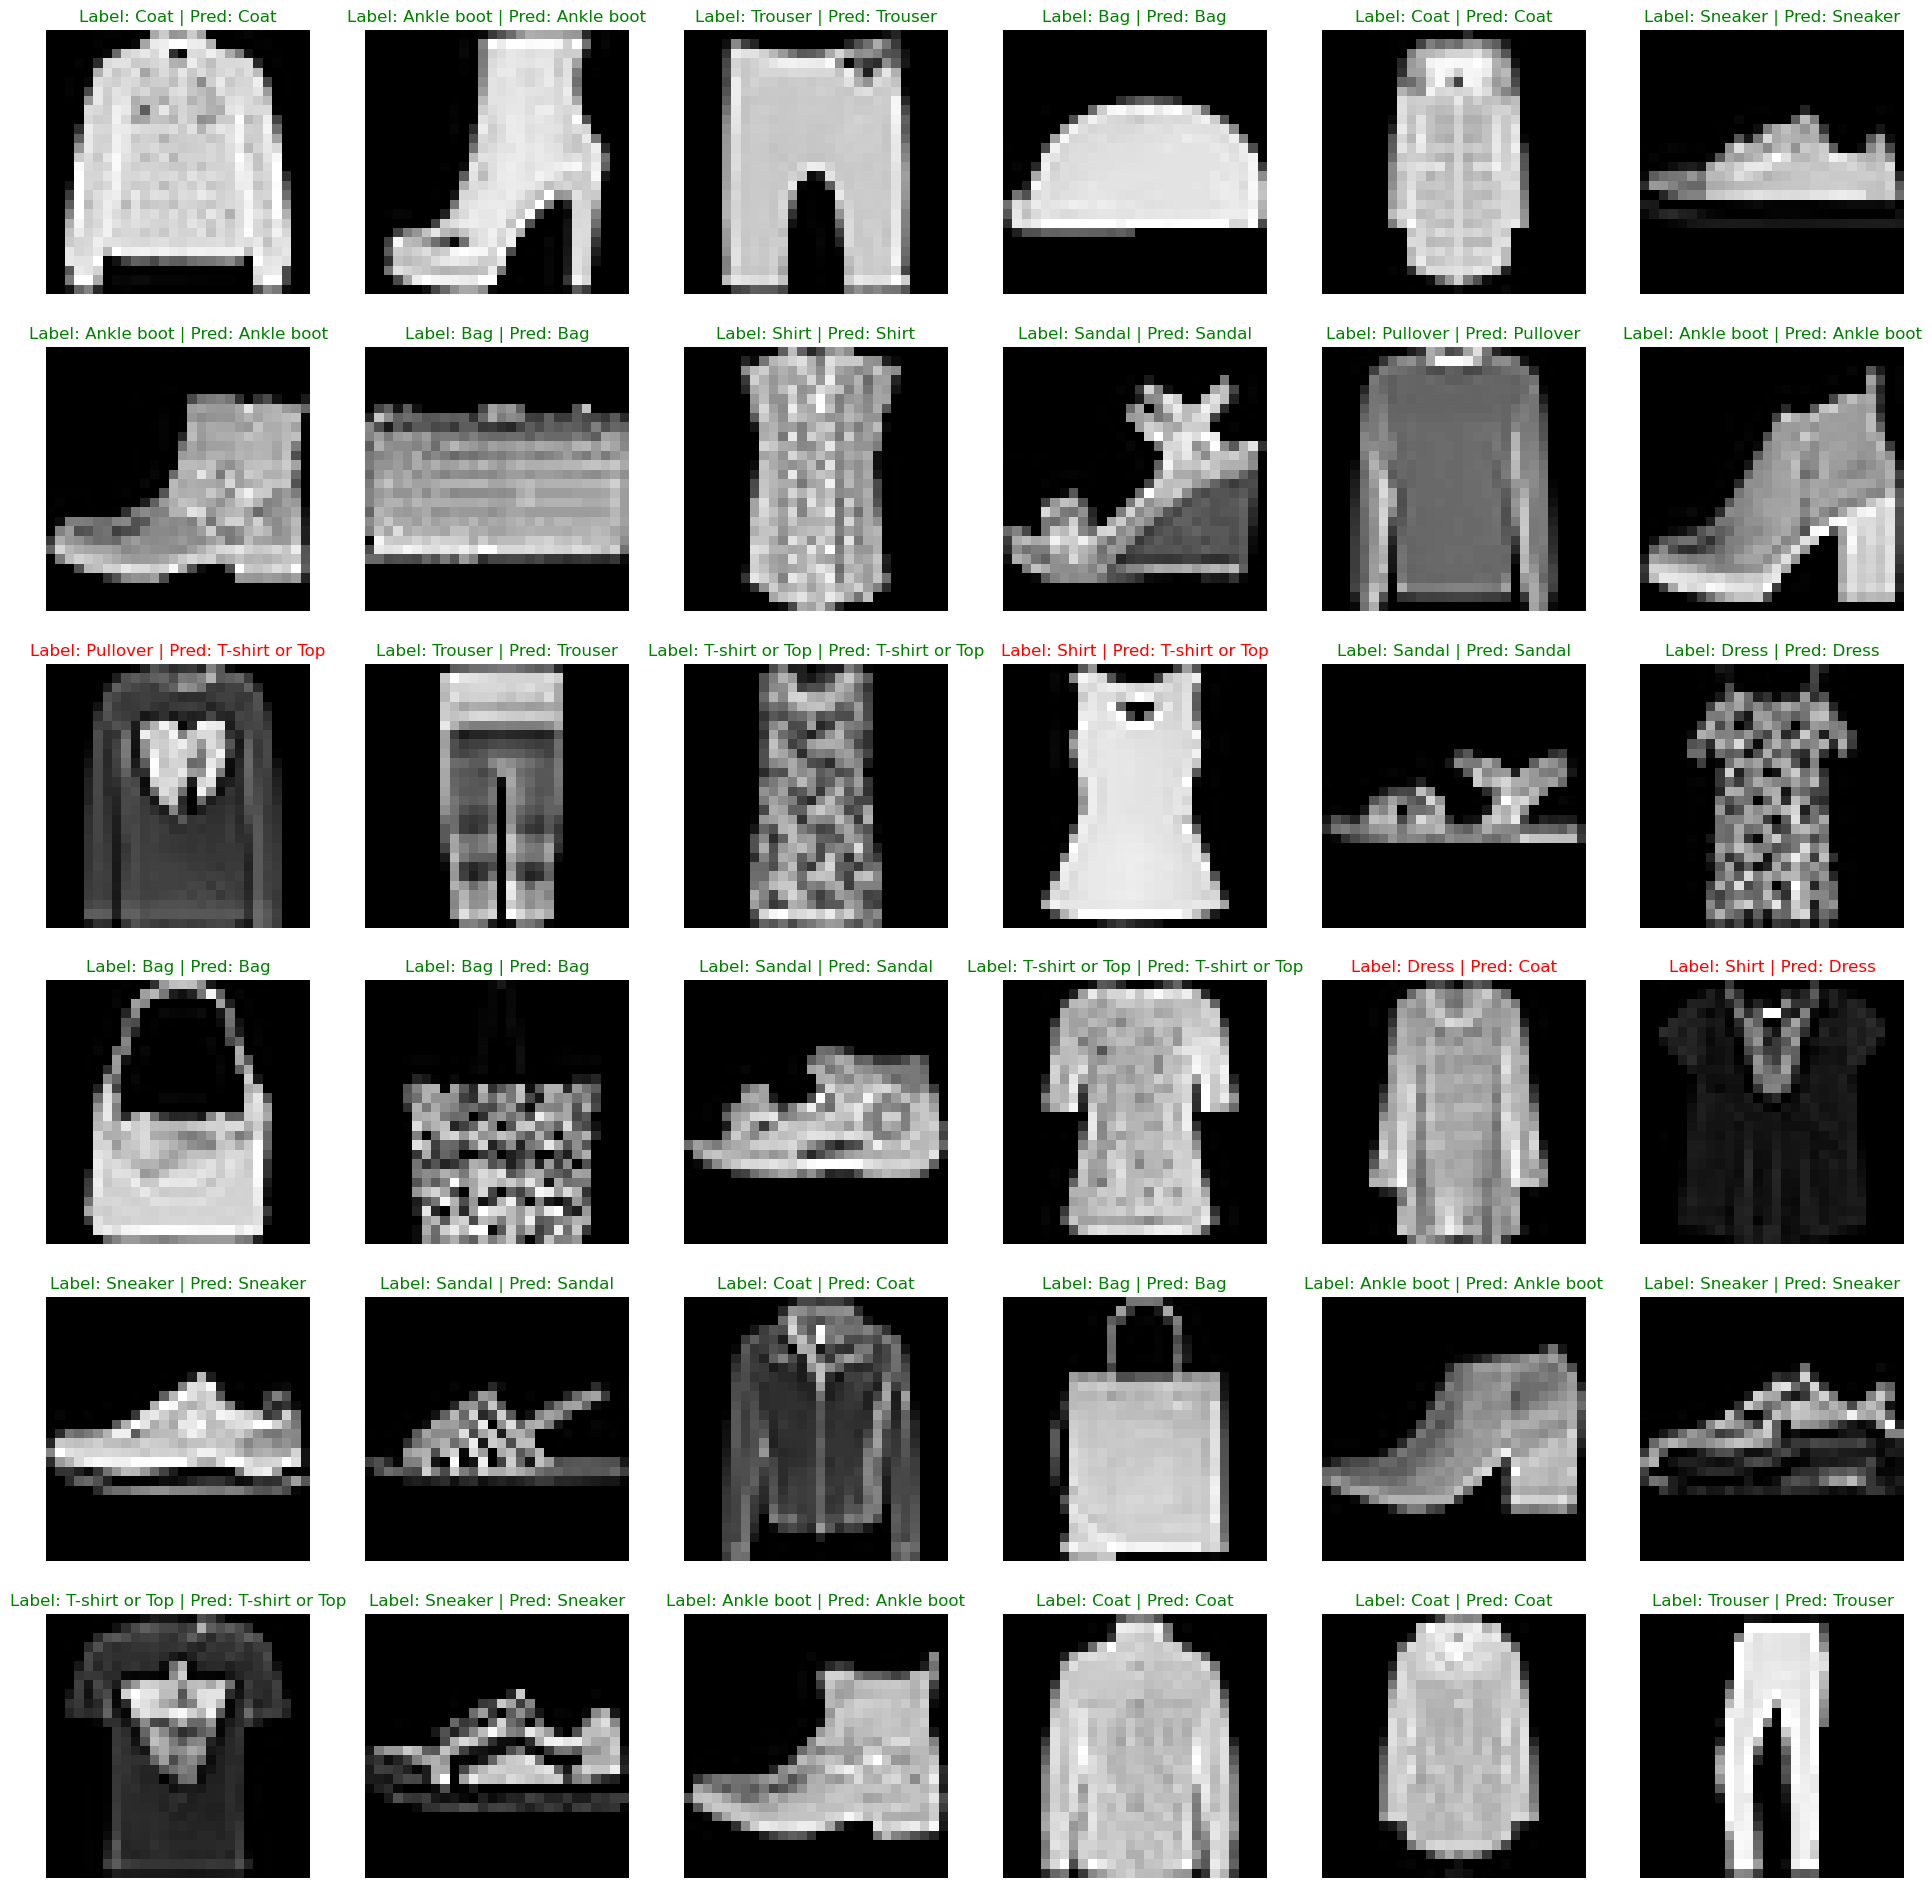

In [27]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.view(28, 28).cpu(), cmap='gray')
    font = {"color": 'r' if label != pred else 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font)
    ax.axis('off')

- Bagaimana aktivitas mentoring dan koordinasi dengan Mentor & DPP?
- Apa yang telah kamu kerjakan dan bagaimana perkembangannya?
- Tantangan apa yang dihadapi dan berikan alternatif solusi untuk menghadapinya?
- Apa saja dan jelaskan pengembangan kompetensi yang telah didapat?